In [1]:
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
start_date = datetime(2016,1,1)
end_date = datetime(2021,1,1)

In [3]:
market = Market()
speculation_db = ADatabase("strategy_speculation")

In [4]:
market.connect()
prices = market.retrieve("prices")
sp5 = market.retrieve("sp500")
market.disconnect()

In [5]:
prices = p.column_date_processing(prices)

In [6]:
prices["year"] = [x.year for x in prices["date"]]
prices["week"] = [x.week for x in prices["date"]]
prices["quarter"] = [x.quarter for x in prices["date"]]

In [7]:
data = []
for ticker in tqdm(sp5["Symbol"]):
    ticker_data = prices[prices["ticker"]==ticker]
    ticker_data.sort_values("date",ascending=True)
    ticker_data = ticker_data.groupby(["year","week"]).mean().reset_index()
    for i in range(14):
        ticker_data[str(i)] = ticker_data["adjclose"].shift(i)
    ticker_data["d1"] = ticker_data["adjclose"].pct_change(periods=7)
    ticker_data["d2"] = ticker_data["d1"].pct_change(periods=1)
    ticker_data["d3"] = ticker_data["d2"].pct_change(periods=1)
    ticker_data.dropna(inplace=True)
    ticker_data["ticker"] = ticker
    data.append(ticker_data)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [02:00<00:00,  4.21it/s]


In [8]:
final_data = pd.concat(data)

In [19]:
start_year = 2016
end_year = 2022
sim = []
speculation_db.connect()
for year in tqdm(range(start_year,end_year)):
    try:
        ticker_data = final_data.copy()
        factors = [str(i) for i in range(14)]
        factors.append("d1")
        factors.append("d2")
        factors.append("d3")
        training_data = ticker_data[(ticker_data["year"]<year) & (ticker_data["year"]>=year-5)].reset_index(drop=True)
        training_data.dropna(inplace=True)
        prediction_data = ticker_data[ticker_data["year"]==year].dropna()
        if training_data.index.size > 100:
            refined_data = {"X":training_data[factors],"y":training_data[["adjclose"]].rename(columns={"adjclose":"y"})}
            models = m.regression(refined_data)
            for row in models.iterrows():
                try:
                    model = row[1]["model"]
                    api = row[1]["api"]
                    score = row[1]["score"]
                    prediction_data[f"{api}_prediction"] = model.predict(prediction_data[factors])
                    prediction_data[f"{api}_score"] = score
                except:
                    continue
            included_columns = ["year","week","ticker"]
            included_columns.extend([x for x in prediction_data.columns if "score" in x or "prediction" in x])
            sim.append(prediction_data[included_columns])
        else:
            continue
    except Exception as e:
        print(year,str(e))
speculation_db.disconnect()

Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
[11:44:18] C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/data/data.cc:981: Check failed: valid: Input data contains `inf` or `nan`


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
[11:44:51] C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/data/data.cc:981: Check failed: valid: Input data contains `inf` or `nan`
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
[11:45:27] C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/data/data.cc:981: Check failed: valid: Input data contains `inf` or `nan`
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
[11:46:05] C:/Users/Administrator/workspace/xgboost-

In [12]:
start_year = 2022
end_year = 2023
speculation_db.connect()
for year in range(start_year,end_year):
    for ticker in tqdm(sp5["Symbol"]):
        try:
            ticker_data = final_data[final_data["ticker"]==ticker]
            factors = [str(i) for i in range(14)]
            training_data = ticker_data[(ticker_data["year"]<year) & (ticker_data["year"]>=year-5)].reset_index(drop=True)
            prediction_data = ticker_data[ticker_data["year"]==year]
            if training_data.index.size > 100:
                refined_data = {"X":training_data[factors],"y":training_data[["adjclose"]].rename(columns={"adjclose":"y"})}
                models = m.regression(refined_data)
                models["model"] = [pickle.dumps(x) for x in models["model"]]
                models["ticker"] = ticker
                models["year"] = year
                speculation_db.store("models",models)
            else:
                continue
        except Exception as e:
            print(year,ticker,str(e))
speculation_db.disconnect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [44:15<00:00,  5.26s/it]Custom logger is already specified. Specify more than one logger at same time is not thread safe.


In [18]:
start_year = 2022
end_year = 2023
speculation_db.connect()
models = speculation_db.retrieve("models")
models["model"] = [pickle.loads(x) for x in models["model"]]
for year in range(start_year,end_year):
    for ticker in tqdm(sp5["Symbol"]):
        try:
            ticker_data = final_data[final_data["ticker"]==ticker]
            factors = [str(i) for i in range(14)]
            prediction_data = ticker_data[ticker_data["year"]==year]
            ticker_model_data = models[(models["ticker"]==ticker) & (models["year"]==year)]
            for row in ticker_model_data.iterrows():
                model = row[1]["model"]
                api = row[1]["api"]
                score = row[1]["score"]
                prediction_data[f"{api}_prediction"] = model.predict(prediction_data[factors])
                prediction_data[f"{api}_score"] = score
            included_columns = ["year","week","ticker"]
            included_columns.extend([x for x in prediction_data.columns if "score" in x or "prediction" in x])
            speculation_db.store("predictions",prediction_data[included_columns].tail(1))
        except Exception as e:
            print(year,ticker,str(e))
speculation_db.disconnect()

 13%|██████████████████████████████▍                                                                                                                                                                                                   | 68/505 [00:03<00:23, 18.30it/s]

strategy_speculation predictions documents must be a non-empty list


 16%|█████████████████████████████████████▏                                                                                                                                                                                            | 83/505 [00:04<00:22, 18.98it/s]

strategy_speculation predictions documents must be a non-empty list


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 498/505 [00:28<00:00, 17.77it/s]

2022 WLTW Found array with 0 sample(s) (shape=(0, 14)) while a minimum of 1 is required.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [00:28<00:00, 17.51it/s]

strategy_speculation predictions documents must be a non-empty list
strategy_speculation predictions documents must be a non-empty list
strategy_speculation predictions documents must be a non-empty list
strategy_speculation predictions documents must be a non-empty list


In [16]:
prediction_data[included_columns]

,year,week,ticker,skl_prediction,skl_score,xgb_prediction,xgb_score,cat_prediction,cat_score
1461,2022,1,MMM,179.082000,1.0,180.043900,0.99604,177.845243,0.987569
1462,2022,2,MMM,178.399896,1.0,178.806824,0.99604,179.480933,0.987569
1463,2022,3,MMM,174.000778,1.0,174.082565,0.99604,175.938945,0.987569
1464,2022,4,MMM,168.136562,1.0,166.232437,0.99604,169.429983,0.987569
1465,2022,5,MMM,163.407963,1.0,163.679764,0.99604,166.373169,0.987569
1466,2022,6,MMM,159.699141,1.0,158.677170,0.99604,162.558508,0.987569
1467,2022,7,MMM,152.513130,1.0,154.194901,0.99604,157.158586,0.987569
1468,2022,8,MMM,146.335000,1.0,146.417267,0.99604,146.205010,0.987569
1469,2022,9,MMM,147.130000,1.0,146.067612,0.99604,147.094151,0.987569
1470,2022,10,MMM,144.034000,1.0,145.957657,0.99604,139.946004,0.987569


In [20]:
simulation = pd.concat(sim).groupby(["year","week","ticker"]).mean().reset_index()
simulation = prices.merge(simulation,on=["year","week","ticker"]).dropna()

In [21]:
simulation["average_prediction"] = [sum([row[1][col] for col in simulation.columns if "prediction" in col]) for row in simulation.iterrows()]

In [22]:
simulation["average_prediction"] = simulation["average_prediction"] / 3
simulation["delta"] = (simulation["average_prediction"] - simulation["close"]) / simulation["close"]

In [23]:
positions = 1
start_date = simulation["date"].min()
end_date = simulation["date"].max()
reqs = [1,3]
limit = 7
values = [True]
trades = []
for value in tqdm(values):
    for req in tqdm(reqs):
        for position in range(positions):
            date = start_date
            iterration_sim = simulation.copy()
            if not value:
                iterration_sim["delta"] = iterration_sim["delta"] * -1
            while date < end_date:
                try:
                    todays_recs = iterration_sim[iterration_sim["date"]==date]
                    todays_recs.sort_values("delta",ascending=False,inplace=True)
                    if todays_recs.index.size > 0:
                        offering = todays_recs.iloc[position]
                        if offering["delta"] > req:
                            trade = offering
                            ticker = trade["ticker"]
                            buy_price = trade["close"]
                            exits = iterration_sim[(iterration_sim["ticker"]==ticker) & (iterration_sim["date"]>date)].iloc[:limit]
                            exits["gains"] = (exits["close"] - buy_price) / buy_price
                            exit = exits.sort_values("gains",ascending=False).iloc[0]
                            trade["sell_price"] = exit["close"]
                            trade["sell_date"] = exit["date"]
                            date = exit["date"] + timedelta(days=1)
                            trade["value"] = value
                            trade["req"] = req
                            trade["position"] = position
                            trades.append(trade)
                        else:
                            date = date + timedelta(days=1)
                    else:
                        date = date + timedelta(days=1)
                except Exception as e:
                    print(str(e))
                    date = date+timedelta(days=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:14<00:00, 74.15s/it]


In [24]:
t = pd.DataFrame(trades)

In [25]:
t["delta"] =  (t["sell_price"] - t["close"]) / t["close"]

In [26]:
analysis = []
for value in tqdm(values):
    for req in tqdm(reqs):
        for position in range(positions):
            position_trades = t[(t["value"]==value) & (t["req"]==req) & (t["position"]==position)].sort_values("date")
            position_trades["delta"] = (position_trades["sell_price"] - position_trades["close"]) / position_trades["close"]
            initial = 100 / positions
            for delta in position_trades["delta"]:
                initial = initial * (1+delta)
            analysis.append({
                "value":value,
                "req":req,
                "position":position,
                "pv":initial
            })

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.81it/s]


In [27]:
complete = pd.DataFrame(analysis).pivot_table(index=["value","req"],columns="position",values="pv").reset_index()

In [28]:
complete["pv"] = [sum([row[1][i] for i in range(5)]) for row in complete.iterrows()]

In [29]:
complete.sort_values("pv",ascending=False)

position,value,req,0,1,2,3,4,pv
0,True,1,2499.747713,45.625198,20.0,20.0,20.0,2605.372911
1,True,3,34.705322,20.000000,20.0,20.0,20.0,114.705322


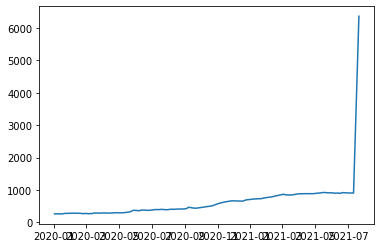

In [36]:
best_iteration = t[(t["value"]==True) & (t["req"]==1)].copy()
pivoted = best_iteration.pivot_table(index="date",columns="position",values="delta").fillna(0)
for i in range(2):
    pv = []
    initial = 50
    for delta in pivoted[i]:
        initial = initial * (1+delta)
        pv.append(initial)
    pivoted[f"pv_{i}"] = pv
pivoted["pv"] = [sum([row[1][f"pv_{i}"] for i in range(2)]) for row in pivoted.iterrows()]
pivoted.reset_index(inplace=True)
window = pivoted[pivoted["date"]>datetime(2020,1,1)]
plt.plot(window["date"],window["pv"])